# AutoRec

**Autor**: Arturo Sánchez Palacio

Basado en: https://github.com/lazyprogrammer

**Fecha de última revisión: 18/I/2020**

Como siempre comenzamos instalando los módulos que necesitamos e importándolos:

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import save_npz, load_npz
import keras.backend as K

Using TensorFlow backend.


Comenzamos cargando las matrices sparse que hemos generado en el notebook `preprocessing_sparse.ipynb`:

In [2]:
A = load_npz("./data/Atrain.npz")
A_test = load_npz("./data/Atest.npz")

Creamos de nuevo variables máscara para saber que entradas están ocupadas y cuáles no:

In [3]:
mask = (A > 0) * 1.0 #usamos condicion 0 porque todos los ratings están entre 0.5 y 5.
mask_test = (A_test > 0) * 1.0

Realizmaos copias de las matrices porque el generador va a mezclar los datos y no queremos que a la hora de hacer comprobaciones en el test los elementos hayan cambiado de orden:

In [4]:
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

Configuramos los parámetros de la red:

In [5]:
batch_size = 128
iteraciones = 20
reg = 0.0001

En este caso N y M se pueden inferir del tamaño de la matriz:

In [6]:
N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

N: 138493 M: 26744
N // batch_size: 1081


Calculamos la media global:

In [7]:
mu = A.sum() / mask.sum() #usamos mask.sum() porque nos indica cuantos valores existen (matriz de 1's y 0's)

Ya estamos listos para empezar a construir el modelo. En este caso construiremos un Autoencoder con una sola capa oculta:

In [8]:
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
i = Input(shape=(M,)) # la entrada es
x = Dropout(0.3)(i) # permite que la neurona aprenda a predecir ratings desconocidos
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x) #capa con 700 neuronas y regularización
x = Dense(M, kernel_regularizer=l2(reg))(x) #capa densa con 26744 neuronas y regularización




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Tenemos que definir una función de pérdida personalizada. No es posible utilizar la implementada en Keras como hasta ahora porque tendría en cuenta también el error en aquellos ratings no definidos (no tiene sentido porque si no están definidos no puede haber error).

In [9]:
def custom_loss(y_real, y_pred):
    mask = K.cast(K.not_equal(y_real, 0), dtype='float32') #mascara que comprueba los espacios de la matriz real que no son 0. Lo casteamos de booleanoa a float
    diff = y_pred - y_real # Calculamos la diferencia entre lo predicho y lo real.
    sqdiff = diff * diff * mask #Valoramos solo los lugares que marcamos con la máscara
    sse = K.sum(K.sum(sqdiff)) #Calculamos la suma del error cuadrático
    n = K.sum(K.sum(mask)) #número de observaciones que existen
    return sse / n #Calculamos el error cuadrático medio

A continuación definimos nuestra propia función generador para el entrenamiento:

In [12]:
def generator(A, M):
    while True:
        A, M = shuffle(A, M) #mezclamos los datos
        for i in range(A.shape[0] // batch_size + 1): # recorremos los datos en batches: (+1 porque es división entera)
            upper = min((i+1)*batch_size, A.shape[0]) # para no salirnos del array
            a = A[i*batch_size:upper].toarray() # batch actual
            m = M[i*batch_size:upper].toarray() # mascara del batch
            a = a - mu * m # centramos el dato (mejora la performance (multiplicamos por m para que los 0 sean 0))
            m2 = (np.random.random(a.shape) > 0.5) #añadimos mas ruido para que el autoencoder aprenda a predecir valores perdidos
            noisy = a * m2
            #noisy = a # quitar comentario si quisiéramos trabajar sin ruido
            yield noisy, a

Definimos el generador de test. 

__Nota importante.__ Está asumiendo que `A` y `A_test` están en orden por eso es importante usar las copias.

In [13]:
def test_generator(A, M, A_test, M_test):
    while True:
        for i in range(A.shape[0] // batch_size + 1): # recorremos los datos en batches
            upper = min((i+1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray() # batch actual
            m = M[i*batch_size:upper].toarray() # máscara del batch 
            at = A_test[i*batch_size:upper].toarray() # batch actual tesst
            mt = M_test[i*batch_size:upper].toarray() # máscara del batch test
            a = a - mu * m #centra dato con media global
            at = at - mu * mt # usa media global y no ajutada al test (sería trampa la del test)
            yield a, at

Ya estamos listos para instanciar el modelo:

In [14]:
from keras.models import Model
model = Model(i, x)

Compilamos el modelo usando la función de pérdida que hemos definido previamente:

In [15]:
from keras.optimizers import SGD
model.compile(
  loss=custom_loss, #esto nos devuleve el mse con regularización en la historia
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=[custom_loss], # Esto hace que nos devuelva solo el mse (menor que con regularización)
)

Este es el resumen de nuestro modelo:

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26744)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26744)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 700)               18721500  
_________________________________________________________________
dense_2 (Dense)              (None, 26744)             18747544  
Total params: 37,469,044
Trainable params: 37,469,044
Non-trainable params: 0
_________________________________________________________________


Y finalmente entrenamos el modelo. Observemos que se emplean los generadores previamente definidos y que en los datos de validación se emplean las copias de las matrices para conservar el orden:

In [17]:
r = model.fit_generator(
  generator(A, mask),
  validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=iteraciones,
  steps_per_epoch=A.shape[0] // batch_size + 1, 
  validation_steps=A_test.shape[0] // batch_size + 1,
)
print(r.history.keys())


Epoch 1/20
 102/1082 [=>............................] - ETA: 14:02 - loss: 1.3211 - custom_loss: 1.0518

KeyboardInterrupt: 

De nuevo observamos los resultados mediante gráficas:

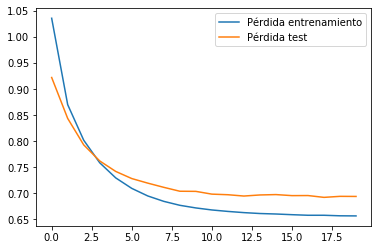

In [16]:
plt.plot(r.history['loss'], label="Pérdida entrenamiento")
plt.plot(r.history['val_loss'], label="Pérdida test")
plt.legend()
plt.show()

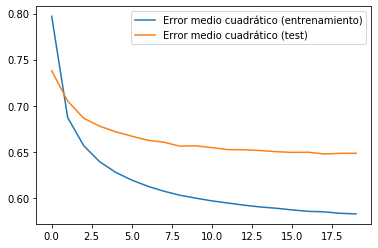

In [17]:
plt.plot(r.history['custom_loss'], label="Error medio cuadrático (entrenamiento)")
plt.plot(r.history['val_custom_loss'], label="Error medio cuadrático (test)")
plt.legend()
plt.show()